## Test notebook

In [1]:
import pandas as pd
import nltk
pd.set_option('display.max_colwidth', None)
from nltk.corpus import stopwords 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import pickle 
import numpy as np
nltk.download('words')
nltk. download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download("wordnet")
from joblib import dump, load

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\wangj\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wangj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wangj\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wangj\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1. Read Pre-Processed Data 
#### Change the file path here ../data/airline_reviews_preprocessed.csv

In [2]:

df = pd.read_csv("../data/airline_reviews_preprocessed.csv")
df.drop(columns=['Unnamed: 0.1'], inplace=True)
df[:1]

,Unnamed: 0,airline,review_date,customer_review,traveller_type,cabin,overall,recommended,bigrams,bigram_list,unigram_noun_list,sentiment_rating
0,0,turkish airlines,2019-05-08,first time id flown tk find good cabin crew plane food nice great ground ground staff call centre computer system flight lhr delay miss connection istanbul ground staff dont speak english give contradictory instruction could speak little english eventually get flight izmir three hour later wasnt easy process make bad vast distance walk gate cavernous new airport id phone tk call centre base ukraine pay extra way extra leg room seat departure time keep change seat keep change return leg london istanbul give extra leg room seat luckily spare exit row seat cabin crew sort overall think cabin crew plane good ground staff call centre staff need good train need good computer system software work,Business,Economy Class,7,True,"[('first', 'time'), ('time', 'id'), ('id', 'flown'), ('flown', 'tk'), ('tk', 'find'), ('find', 'good'), ('good', 'cabin'), ('cabin', 'crew'), ('crew', 'plane'), ('plane', 'food'), ('food', 'nice'), ('nice', 'great'), ('great', 'ground'), ('ground', 'ground'), ('ground', 'staff'), ('staff', 'call'), ('call', 'centre'), ('centre', 'computer'), ('computer', 'system'), ('system', 'flight'), ('flight', 'lhr'), ('lhr', 'delay'), ('delay', 'miss'), ('miss', 'connection'), ('connection', 'istanbul'), ('istanbul', 'ground'), ('ground', 'staff'), ('staff', 'dont'), ('dont', 'speak'), ('speak', 'english'), ('english', 'give'), ('give', 'contradictory'), ('contradictory', 'instruction'), ('instruction', 'could'), ('could', 'speak'), ('speak', 'little'), ('little', 'english'), ('english', 'eventually'), ('eventually', 'get'), ('get', 'flight'), ('flight', 'izmir'), ('izmir', 'three'), ('three', 'hour'), ('hour', 'later'), ('later', 'wasnt'), ('wasnt', 'easy'), ('easy', 'process'), ('process', 'make'), ('make', 'bad'), ('bad', 'vast'), ('vast', 'distance'), ('distance', 'walk'), ('walk', 'gate'), ('gate', 'cavernous'), ('cavernous', 'new'), ('new', 'airport'), ('airport', 'id'), ('id', 'phone'), ('phone', 'tk'), ('tk', 'call'), ('call', 'centre'), ('centre', 'base'), ('base', 'ukraine'), ('ukraine', 'pay'), ('pay', 'extra'), ('extra', 'way'), ('way', 'extra'), ('extra', 'leg'), ('leg', 'room'), ('room', 'seat'), ('seat', 'departure'), ('departure', 'time'), ('time', 'keep'), ('keep', 'change'), ('change', 'seat'), ('seat', 'keep'), ('keep', 'change'), ('change', 'return'), ('return', 'leg'), ('leg', 'london'), ('london', 'istanbul'), ('istanbul', 'give'), ('give', 'extra'), ('extra', 'leg'), ('leg', 'room'), ('room', 'seat'), ('seat', 'luckily'), ('luckily', 'spare'), ('spare', 'exit'), ('exit', 'row'), ('row', 'seat'), ('seat', 'cabin'), ('cabin', 'crew'), ('crew', 'sort'), ('sort', 'overall'), ('overall', 'think'), ('think', 'cabin'), ('cabin', 'crew'), ('crew', 'plane'), ('plane', 'good'), ('good', 'ground'), ('ground', 'staff'), ('staff', 'call'), ('call', 'centre'), ('centre', 'staff'), ('staff', 'need'), ('need', 'good'), ('good', 'train'), ('train', 'need'), ('need', 'good'), ('good', 'computer'), ('computer', 'system'), ('system', 'software'), ('software', 'work')]",first_time cabin_good great_ground connection_miss english_give easy_process bad_vast distance_vast cavernous_gate airport_new pay_ukraine extra_way extra_way extra_leg extra_leg exit_spare overall_think good_plane good_ground centre_staff good_train computer_good,time tk cabin crew plane food ground ground staff call centre computer system flight lhr delay connection istanbul ground staff dont contradictory instruction flight hour wasnt process distance walk gate airport id phone tk call centre base pay way leg room seat departure time change seat change return leg london leg room seat exit row seat cabin crew sort think cabin crew plane ground staff call staff train computer system software,pos


### 2. Define functions to extract top n keywords

In [3]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]  
    return results

#Reference- https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.X8ubn1Mza7M

### 3. Visualize Bi-grams using WordCloud

In [4]:
print('Number of unique airline:', df['airline'].nunique())
print(df['airline'].unique())
print('Number of reviews for each airline:',df.groupby(['airline']).size().sort_values(ascending=False))
# You can modify the airline_select to get top n keyword and sentiment analysis for that airline
# eg:airline_select = 'american airlines'
airline_select = ''

Number of unique airline: 81
['turkish airlines' 'qatar airways' 'emirates' 'lufthansa'
 'klm royal dutch airlines' 'virgin america' 'american airlines'
 'delta air lines' 'southwest airlines' 'united airlines'
 'jetblue airways' 'aegean airlines' 'aeroflot russian airlines'
 'aeromexico' 'air canada' 'air new zealand' 'alitalia' 'airasia'
 'asiana airlines' 'avianca' 'austrian airlines' 'british airways'
 'brussels airlines' 'china eastern airlines' 'china southern airlines'
 'copa airlines' 'ethiopian airlines' 'egyptair' 'finnair' 'iberia'
 'ana all nippon airways' 'easyjet' 'korean air' 'latam airlines'
 'lot polish airlines' 'qantas airways' 'air france' 'etihad airways'
 'pegasus airlines' 'royal jordanian airlines' 'ryanair'
 'south african airways' 'saudi arabian airlines' 'tap portugal'
 'eurowings' 'eva air' 'royal air maroc' 'singapore airlines'
 'sas scandinavian' 'swiss intl air lines' 'thai airways' 'air india'
 'air europa' 'air canada rouge' 'airbaltic' 'air china'
 'ca

### a. Extract Keywords 

In [5]:
airlines_lower = df['airline'].str.lower().unique().tolist()
   
airlines_identifier = ['airlines', 'air lines', 'airline', 'air line', 'airways', 'air']
airlines_informal_lower = []
for airline in airlines_lower:
    found = False
    for airline_identifier in airlines_identifier:
        if found == False:
            if str(' '+airline_identifier) in airline:
                airline_informal = airline.replace(str(' '+airline_identifier),'')
                airlines_informal_lower.append(airline_informal)
                found = True

stopwords_extend = set(stopwords.words('english') + airlines_lower + airlines_identifier + airlines_informal_lower + ['one','get','also','however','even','make', 'dont'])

if airline_select != '':
    bigram_list = df[df['airline']==airline_select]['bigram_list']
else:
    bigram_list = df['bigram_list']

cv=CountVectorizer(max_df=0.85,stop_words=stopwords_extend,max_features=20000)
word_count_vector=cv.fit_transform(bigram_list.values.astype('U'))
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)
feature_names=cv.get_feature_names()
tf_idf_vector=tfidf_transformer.transform(cv.transform([str(bigram_list)]))
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
#extract only the top n
keywords=extract_topn_from_vector(feature_names,sorted_items,50) 
keywords

C:\Users\wangj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aer', 'aeroflot', 'african', 'america', 'ana', 'arabia', 'arabian', 'canada', 'cathay', 'china', 'dutch', 'eastern', 'europa', 'france', 'garuda', 'india', 'indonesia', 'international', 'intl', 'jordanian', 'klm', 'line', 'lines', 'lingus', 'lot', 'maroc', 'new', 'nippon', 'pacific', 'polish', 'portugal', 'romanian', 'rouge', 'royal', 'russian', 'sas', 'saudi', 'scandinavian', 'smile', 'south', 'southern', 'swiss', 'tap', 'tarom', 'ukraine', 'virgin', 'zealand'] not in stop_words.
  warnings.warn(
C:\Users\wangj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out inst

{'airport_new': 0.271,
 'extra_way': 0.207,
 'good_ground': 0.189,
 'extra_leg': 0.154,
 'poor_quality': 0.151,
 'bad_flight': 0.13,
 'board_chinese': 0.129,
 'flight_last': 0.123,
 'many_size': 0.123,
 'happy_land': 0.123,
 'cause_terrible': 0.123,
 'new_room': 0.12,
 'good_train': 0.12,
 'drink_separate': 0.12,
 'company_several': 0.12,
 'slept_time': 0.118,
 'flight_inexpensive': 0.117,
 'aircraft_regional': 0.117,
 'plenty_tasty': 0.115,
 'cheap_company': 0.115,
 'economy_premium': 0.115,
 'level_new': 0.114,
 'economy_empty': 0.114,
 'cheapest_next': 0.114,
 'english_give': 0.113,
 'miserable_staff': 0.111,
 'great_ground': 0.11,
 'overall_think': 0.109,
 'big_mess': 0.109,
 'economy_overall': 0.108,
 'bad_value': 0.108,
 'day_total': 0.107,
 'respond_slow': 0.106,
 'centre_staff': 0.106,
 'flight_sandwich': 0.106,
 'complete_disaster': 0.105,
 'fly_wish': 0.104,
 'bad_hand': 0.104,
 'bad_enemy': 0.104,
 'entertainment_inflight': 0.103,
 'available_economy': 0.103,
 'board_poor': 

### b. Use WordCloud to Visualize 

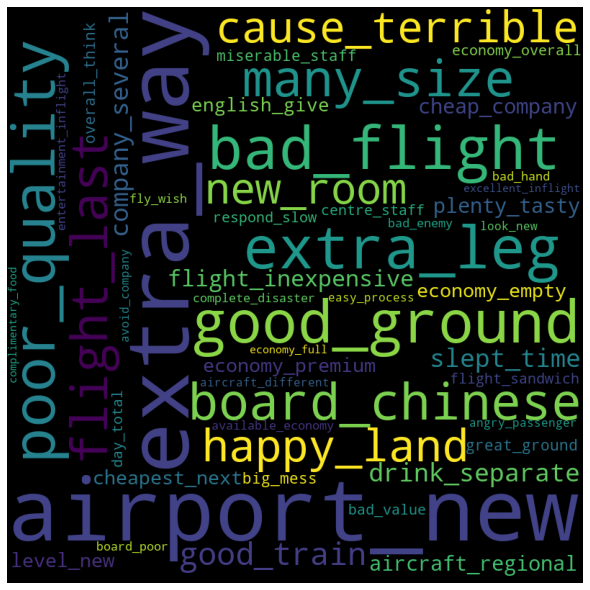

In [6]:
comment_words=""
for k in keywords:
    comment_words+=" "+str(k)      
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='black', 
            stopwords = stopwords_extend, 
            min_font_size = 10).generate(comment_words)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

if airline_select != '':
    filename = airline_select +' airline_review_bigram_wordcloud.png'
else:
    filename = 'airline_review_bigram_wordcloud.png'

plt.savefig(filename)
plt.show() 

### 4. Sentiment Analysis on Unigrams (NN) 

### a. Extract Keywords 

In [7]:
if airline_select != '':
    unigram_list = df[df['airline']==airline_select]['unigram_noun_list']
else:
    unigram_list = df['unigram_noun_list']

cv=CountVectorizer(max_df=0.85,stop_words=stopwords_extend,max_features=10000)
word_count_vector=cv.fit_transform(unigram_list.values.astype('U'))

tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

feature_names=cv.get_feature_names()
tf_idf_vector=tfidf_transformer.transform(cv.transform([str(unigram_list)]))
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())
# Change feature count if you like
feature_count=30
keywords=extract_topn_from_vector(feature_names,sorted_items,feature_count)
#generate tf-idf for the given document
keywords

C:\Users\wangj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aer', 'aeroflot', 'african', 'america', 'ana', 'arabia', 'arabian', 'canada', 'cathay', 'china', 'dutch', 'eastern', 'europa', 'france', 'garuda', 'india', 'indonesia', 'international', 'intl', 'jordanian', 'klm', 'line', 'lines', 'lingus', 'lot', 'maroc', 'new', 'nippon', 'pacific', 'polish', 'portugal', 'romanian', 'rouge', 'royal', 'russian', 'sas', 'saudi', 'scandinavian', 'smile', 'south', 'southern', 'swiss', 'tap', 'tarom', 'ukraine', 'virgin', 'zealand'] not in stop_words.
  warnings.warn(
C:\Users\wangj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out inst

{'kiev': 0.305,
 'flight': 0.257,
 'airport': 0.196,
 'istanbul': 0.19,
 'time': 0.171,
 'crew': 0.169,
 'cabin': 0.168,
 'staff': 0.163,
 'ground': 0.151,
 'ist': 0.146,
 'leg': 0.142,
 'seat': 0.142,
 'uia': 0.138,
 'food': 0.122,
 'interface': 0.114,
 'economy': 0.111,
 'jfk': 0.111,
 'sir': 0.107,
 'room': 0.102,
 'tk': 0.101,
 'experience': 0.095,
 'passenger': 0.094,
 'hurry': 0.094,
 'delay': 0.094,
 'mumbai': 0.092,
 'centre': 0.09,
 'gate': 0.088,
 'company': 0.088,
 'return': 0.088,
 'route': 0.087}

### b. Load Classifier and label keywords
Tester can modify eg: list_outer=["delay","hurry"]

In [8]:
classifier = load('sentiment_analyzer.joblib')
vectorizer = pickle.load(open("vectorizer.pickle", "rb"))
# You can modify the list , give more than 2 keywords below or keep it empty
# eg:list_outer=["delay","hurry"]
list_outer=[]

if not list_outer:
    for k in keywords:
        list_outer.append(" ".join(k.split("_")))

count=len(list_outer)
X_new=vectorizer.transform(list_outer)
X_new.resize(count,10000)
labels=classifier.predict(X_new)
pred_proba=classifier.predict_proba(X_new)
plot_list=[]
for i in range(0,count,1):
    list_inner=[]
    list_inner.append(list_outer[i]) # keywords
    list_inner.append(labels[i]) # keyword sentiment prediction rating
    list_inner.append(max(pred_proba[i])) # sentiment probabilities
    plot_list.append(list_inner)
plot_list[:1]

C:\Users\wangj\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aer', 'aereas', 'aeroflot', 'aerogal', 'aerolineas', 'african', 'aigle', 'airpost', 'al', 'algerie', 'america', 'ana', 'angkor', 'angola', 'arabia', 'arabian', 'argentinas', 'arkia', 'aseman', 'asia', 'astana', 'austral', 'australia', 'aviacin', 'aviation', 'azores', 'azul', 'azur', 'ba', 'bagan', 'bangladesh', 'barbara', 'beijing', 'belgium', 'belize', 'berlin', 'biman', 'binter', 'bird', 'bmi', 'boliviana', 'botswana', 'brasil', 'brasileiras', 'brunei', 'busan', 'cabo', 'cairo', 'cambodia', 'canada', 'canadian', 'canarias', 'capital', 'caraibes', 'cathay', 'cebu', 'central', 'cityflyer', 'colombia', 'com', 'compagnie', 'cook', 'corsica', 'country', 'csa', 'customer', 'czech', 'de', 'dolomiti', 'dutch', 'eagle', 'east', 'el', 'era', 'europa', 'europe', 'expr

[['kiev', 'pos', 0.5526988075722378]]

### c. Plot Sentiment, probabilities and the keywords

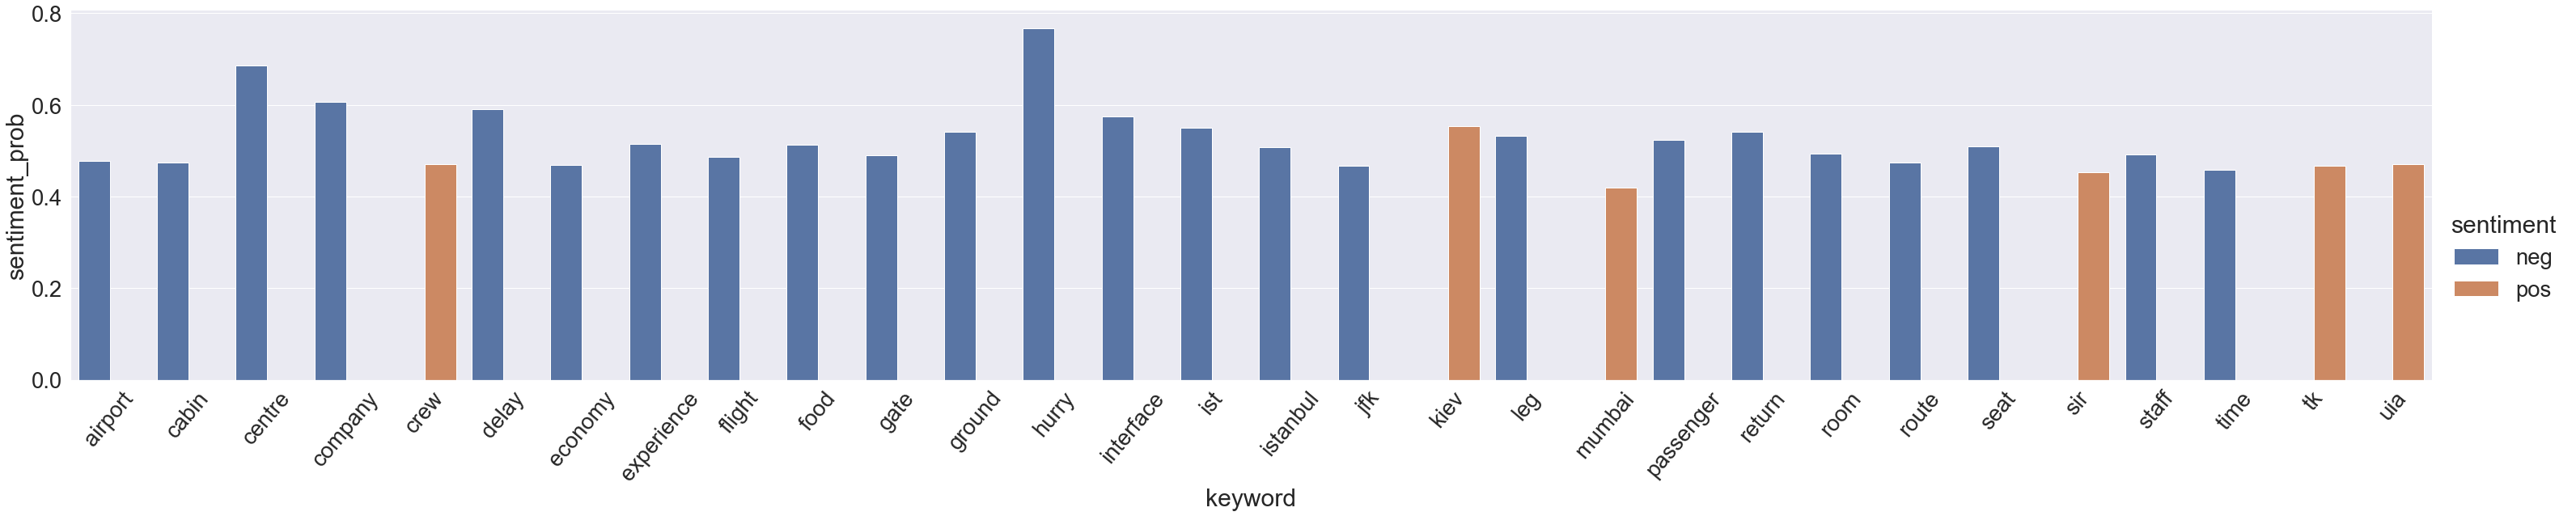

In [9]:
import seaborn as sns
from matplotlib import rcParams
sns.set(font_scale=2.5)
# figure size in inches
rcParams['figure.figsize'] = 300,200
my_np_array=np.array(sorted(plot_list)[:count])
my_np_array=my_np_array.reshape(count,3)
df_plot = pd.DataFrame(my_np_array, columns=['keyword','sentiment','sentiment_prob'])
df_plot=df_plot.astype({'sentiment_prob': 'float'})
plot=sns.catplot(x="keyword", y="sentiment_prob", hue="sentiment",kind="bar", data=df_plot, height=8.27, aspect=11.7/2.27)
plot.set_xticklabels(rotation=50)

if airline_select != '':
    filename = airline_select +' Airline_Aspectsentiment_prob.png'
else:
    filename = 'Airline_Aspectsentiment_prob.png'

plot.savefig(filename)